# 0.0. IMPORTS

In [1]:
import math
import random
import pickle
import datetime
import requests
import warnings
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std( mae_list ), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std( mape_list ), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std( rmse_list ), 2).astype(str)}, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat ) / y)
     
    
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat ) / y) 
    
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae, 
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimension

In [7]:
print(f'Number of rows: {df1.shape[0] }')
print(f'Number of rows: {df1.shape[1] }')

Number of rows: 1017209
Number of rows: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Chek NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week           
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [13]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

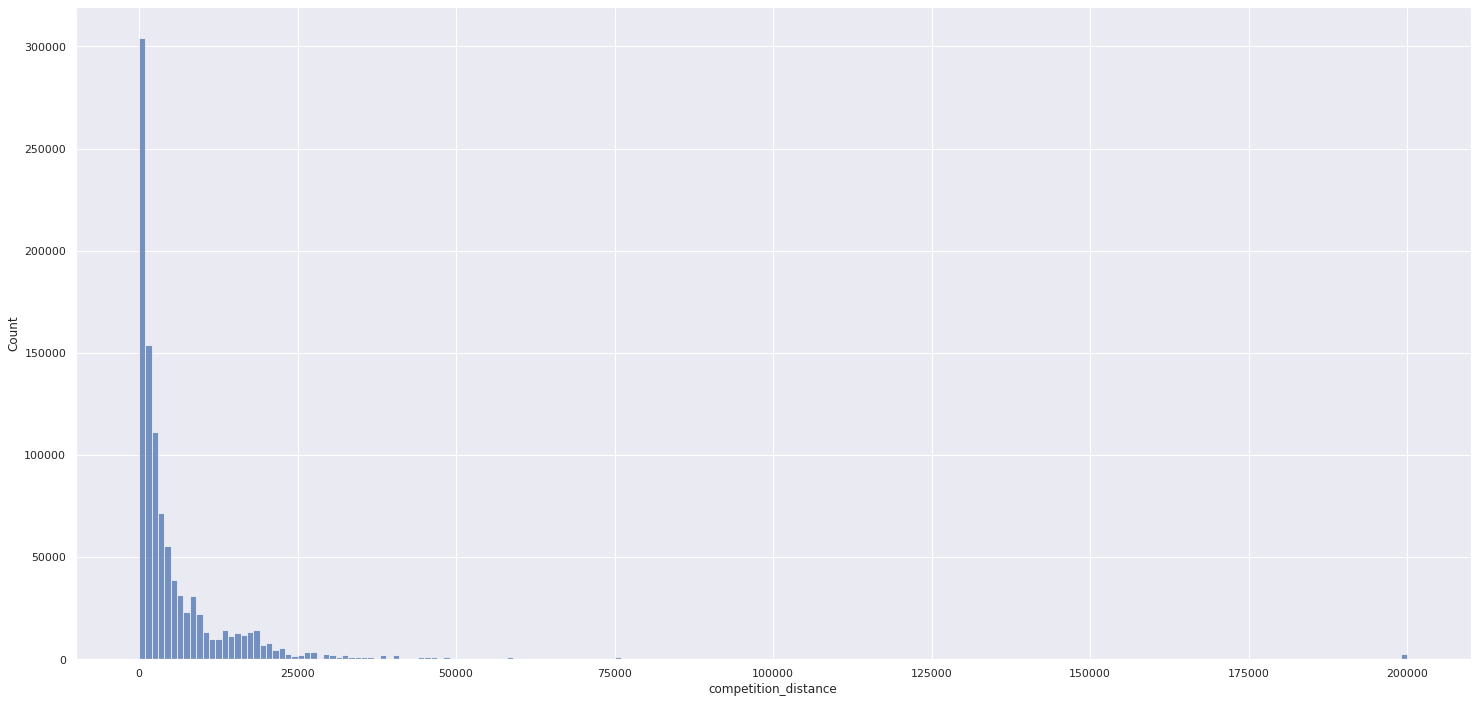

In [16]:
sns.histplot(df1['competition_distance'], kde=False, bins=200)

### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

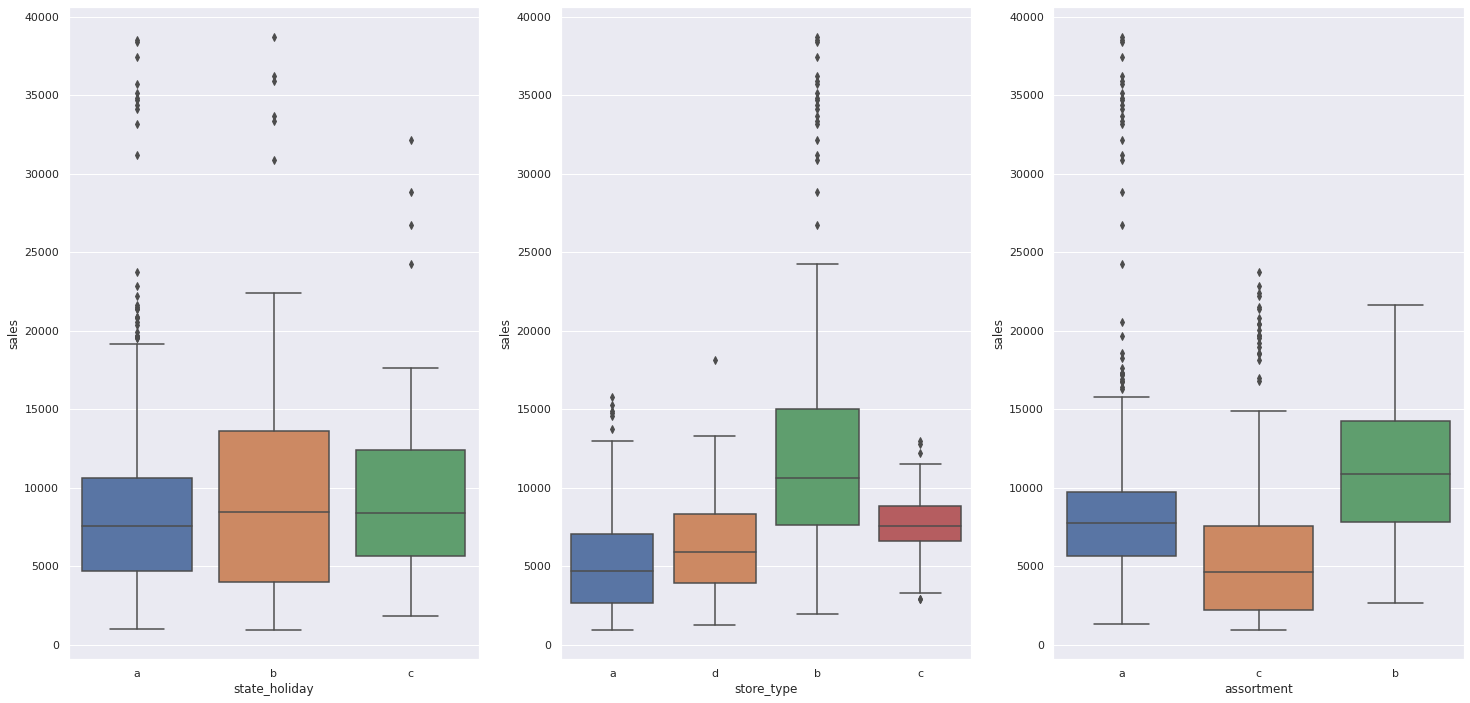

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

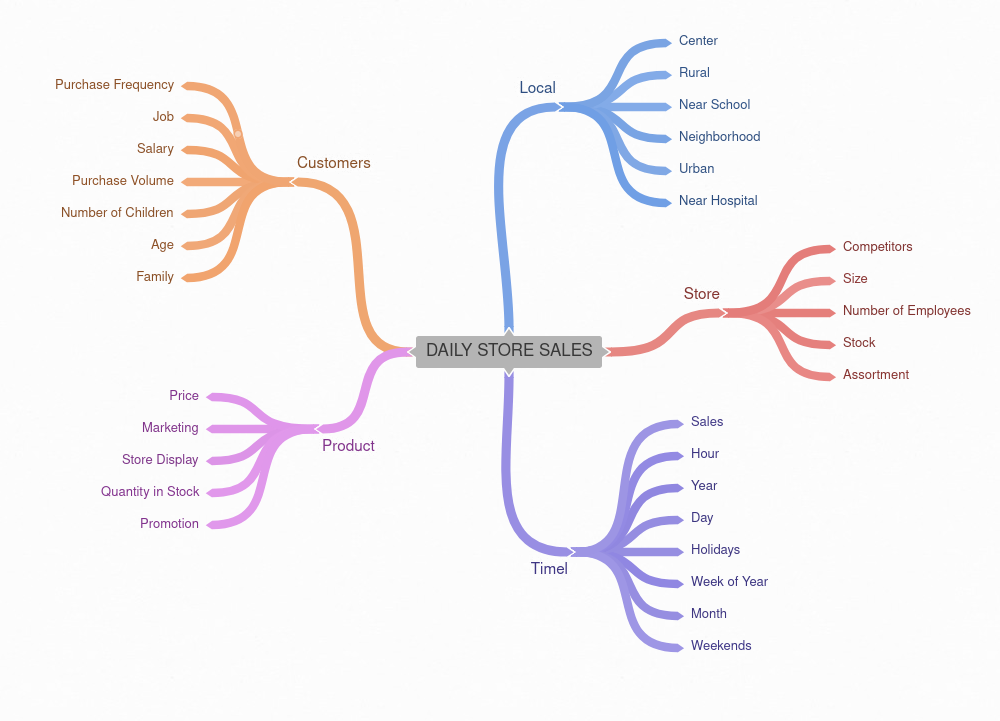

In [20]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with more employees should sell more;

**2.** Stores with higher stock capacity should sell more;

**3.** Larger stores should sell more;

**4.** Stores with larger assortment should sell more;

**5.** Stores with closer competitors should sell less;

**6.** Stores with competitors for longer should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more in Marketing should sell more;

**2.** Stores with greater product exposure should sell more;

**3.** Stores with lower price products should sell more;

**5.** Stores with better promotions should sell more;

**6.** Stores with active promotions for longer should sell more;

**7.** Stores with more days of promotion should sell more;

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas Day should sell more;

**2.** Stores should sell more over the years;

**3.** Stores should sell more in the second half of the year;

**4.** Stores should sell more after the 10th of each month;

**5.** Stores should sell less on weekends;

**6.** Stores should sell less during school holidays.

## 2.3. Hypothesis Final List

**1.** Stores with larger assortment should sell more;

**2.** Stores with closer competitors should sell less;

**3.** Stores with competitors for longer should sell more;

**4.** Stores with active promotions for longer should sell more;

**5.** Stores with more days of promotion should sell more;

**6.** Stores with more consecutive promotions should sell more;

**7.** Stores open on Christmas Day should sell more;

**8.** Stores should sell more over the years;

**9.** Stores should sell more in the second half of the year;

**10.** Stores should sell more after the 10th of each month;

**11.** Stores should sell less on weekends;

**12.** Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. VARIABLE FILTERING

In [22]:
df3 = df2.copy()

## 3.1. Line Filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecting Rows

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

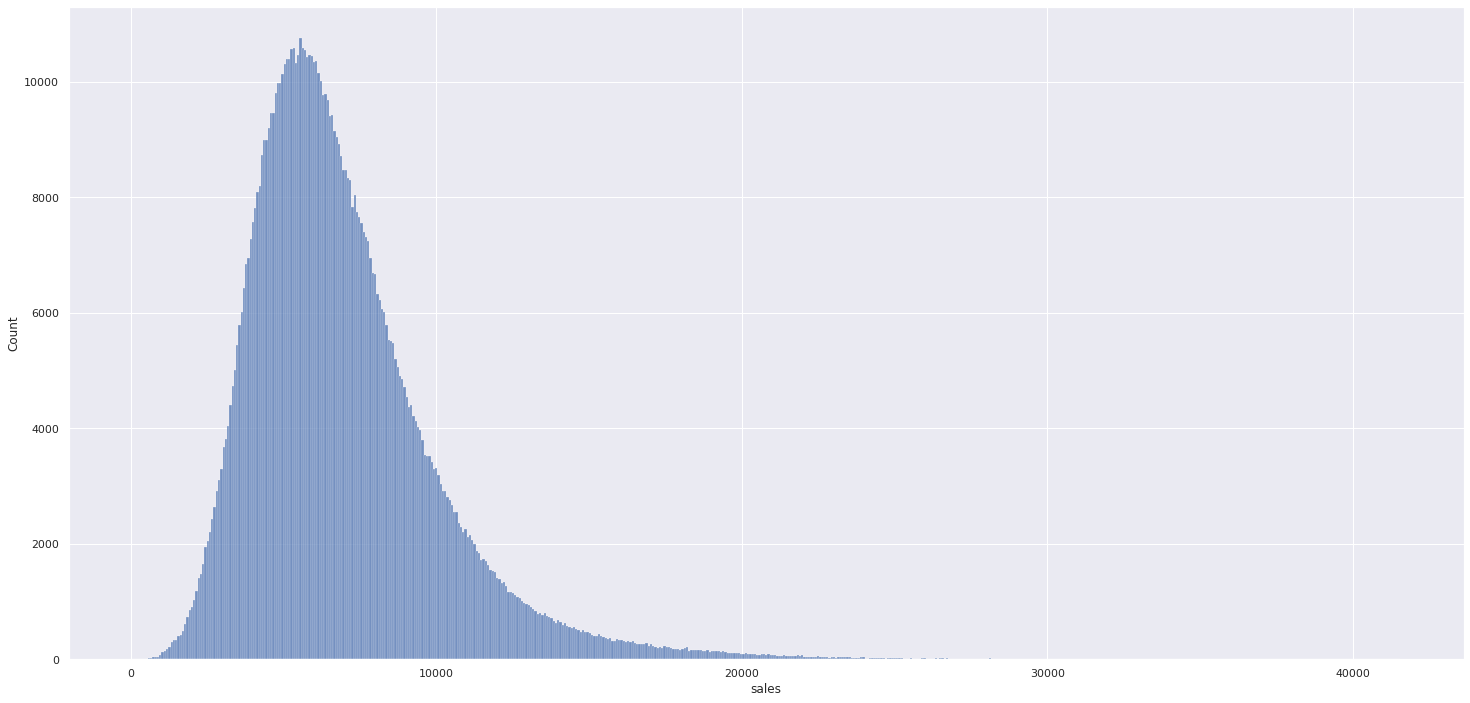

In [26]:
sns.histplot(df4['sales']);

### 4.1.2. Numerical Variable

/home/tcbm/.pyenv/versions/3.8.0/envs/ds_prod/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/tcbm/.pyenv/versions/3.8.0/envs/ds_prod/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/tcbm/.pyenv/versions/3.8.0/envs/ds_prod/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout

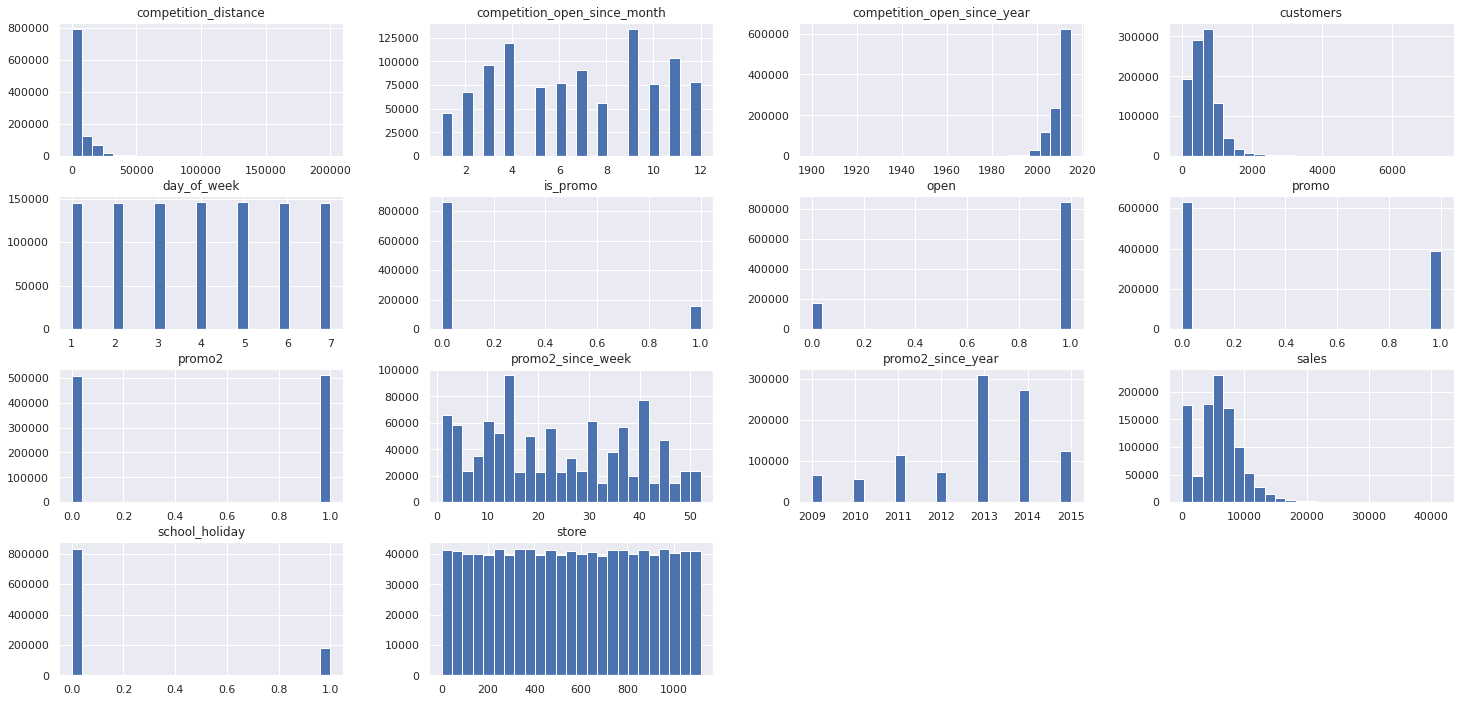

In [27]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

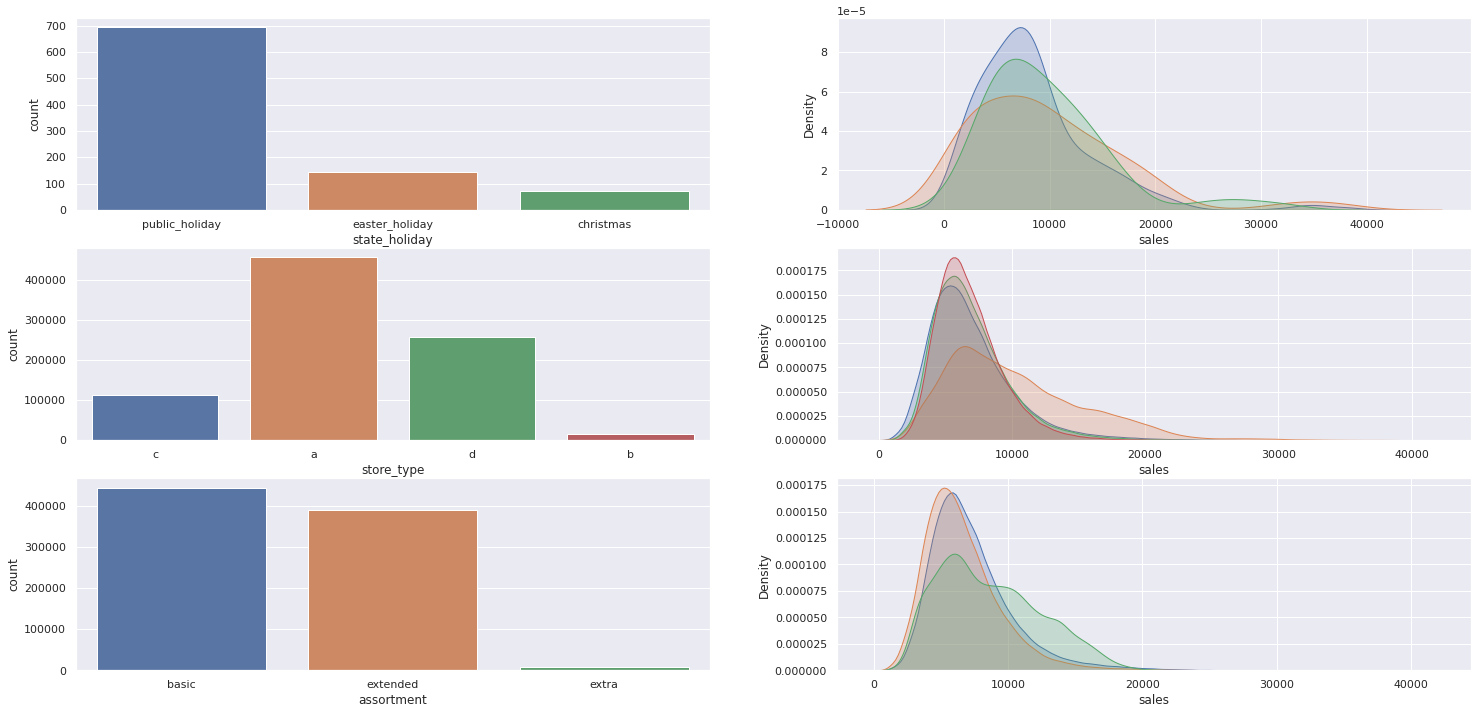

In [28]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])


plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

### 4.2. Bivariate Analysis

### H1. Stores with larger assortment should sell more;
**TRUE** Stores with larger assortment tend to sell more.

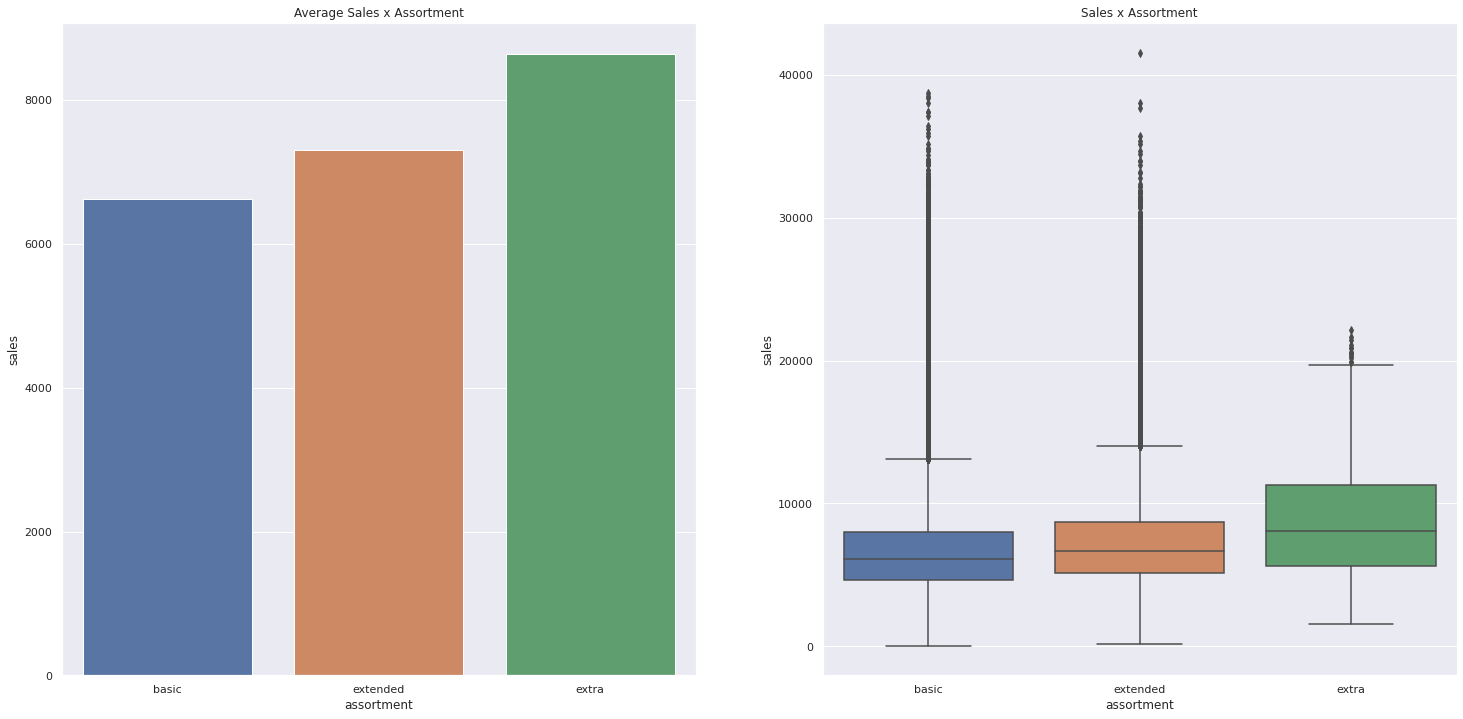

In [29]:
plt.subplot(1, 2, 1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data=aux1);
plt.title('Average Sales x Assortment');

plt.subplot(1, 2, 2)
sns.boxplot(x = 'assortment', y = 'sales', data=df4)
plt.title('Sales x Assortment');

### H2. Stores with closer competitors should sell less;
**FALSE** Competition distance has low influence on sales.

Text(0.5, 1.0, 'Boxplot competition_distance')

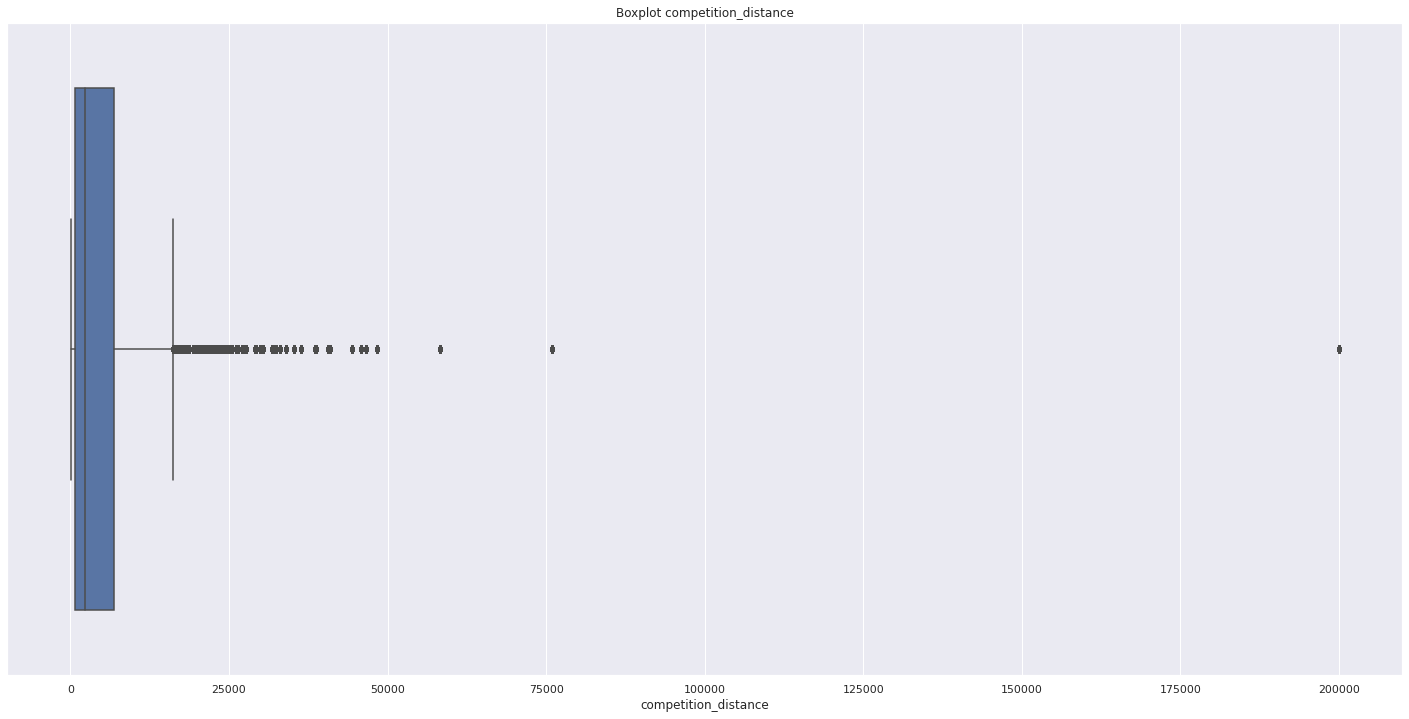

In [30]:
sns.boxplot(x=  df4['competition_distance'])
plt.title('Boxplot competition_distance')

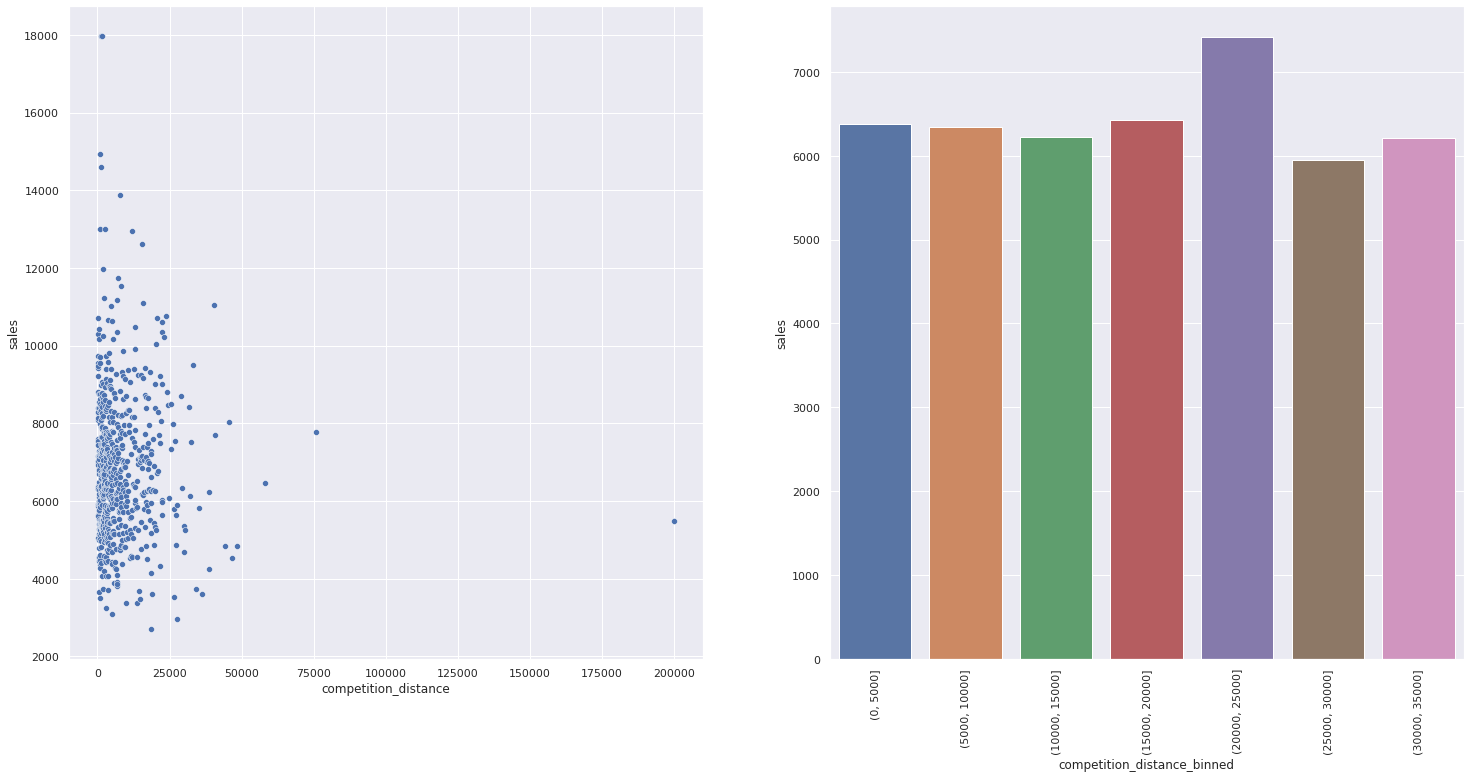

In [31]:
bins = list(np.arange(0, 40000, 5000))
df4['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)

aux1 = df4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
aux2 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(x ='competition_distance', y ='sales', data=aux2)

plt.subplot(1, 2, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux1);
plt.xticks(rotation=90);

df4.drop(columns='competition_distance_binned', axis=1, inplace=True)

### H3. Stores with competitors for longer should sell more.
**FALSE** The competition time has low influence in sales.

Text(0.5, 1.0, 'Boxplot competition_time_month')

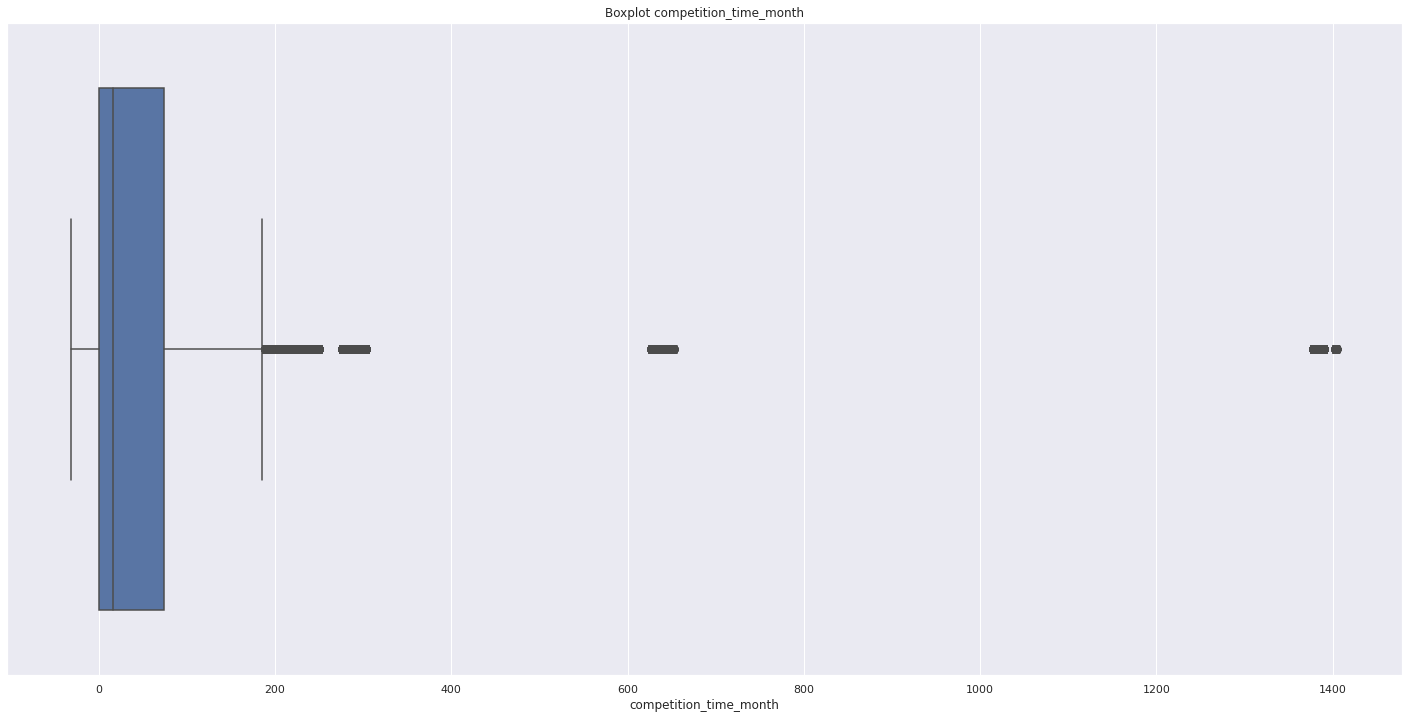

In [32]:
sns.boxplot(x=  df4['competition_time_month'])
plt.title('Boxplot competition_time_month')

Text(0.5, 1.0, 'Pos-Competition')

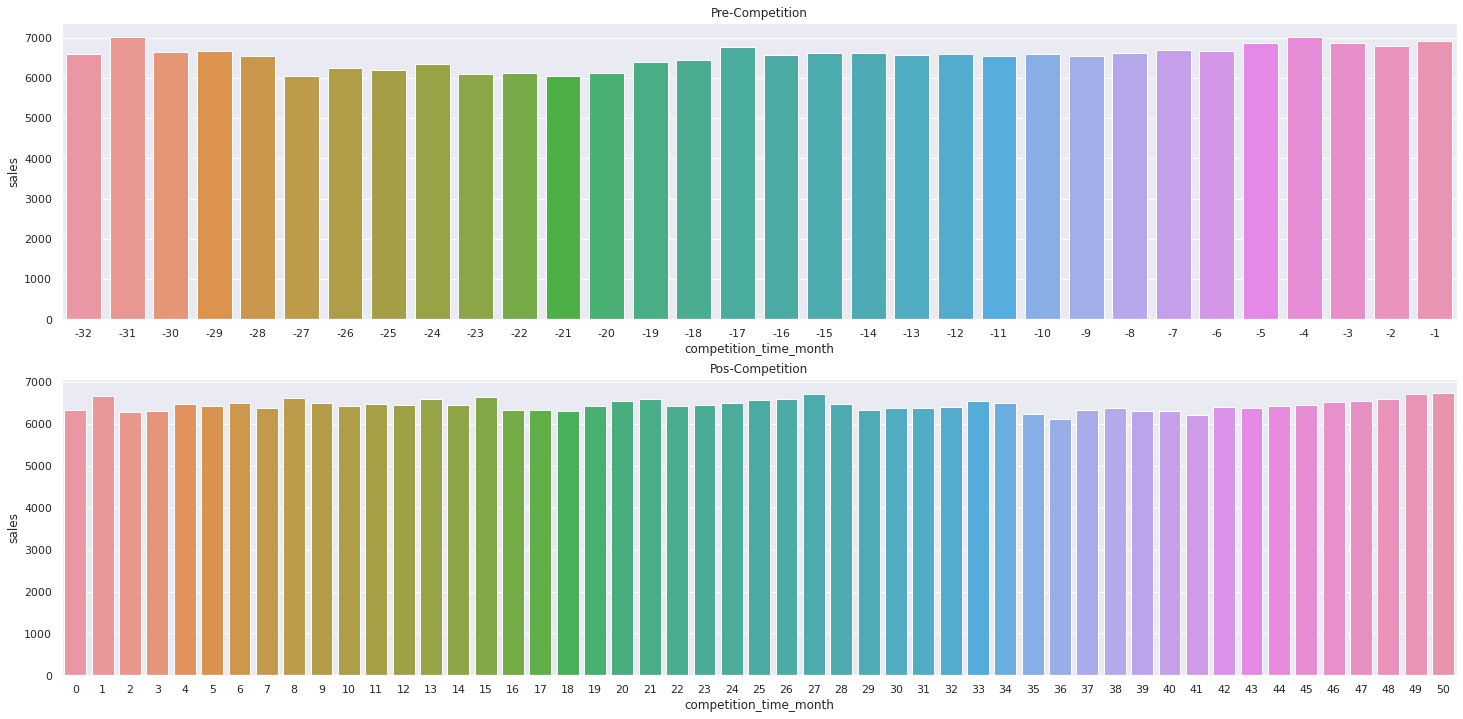

In [33]:
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').median().reset_index() 

aux5 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').count().reset_index() 

neg = aux1[aux1['competition_time_month'] < 0]
posi = aux1[(aux1['competition_time_month'] >=0) & (aux1['competition_time_month'] <= 50)]

plt.subplot(2, 1, 1)
sns.barplot(x='competition_time_month', y='sales', data=neg)
plt.title('Pre-Competition')

plt.subplot(2, 1, 2)
sns.barplot(x='competition_time_month', y='sales', data=posi)
plt.title('Pos-Competition')

### H4. Stores with active promotions for longer should sell more.
**TRUE** Stores with active promotions for longer sell more.

/home/tcbm/.pyenv/versions/3.8.0/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

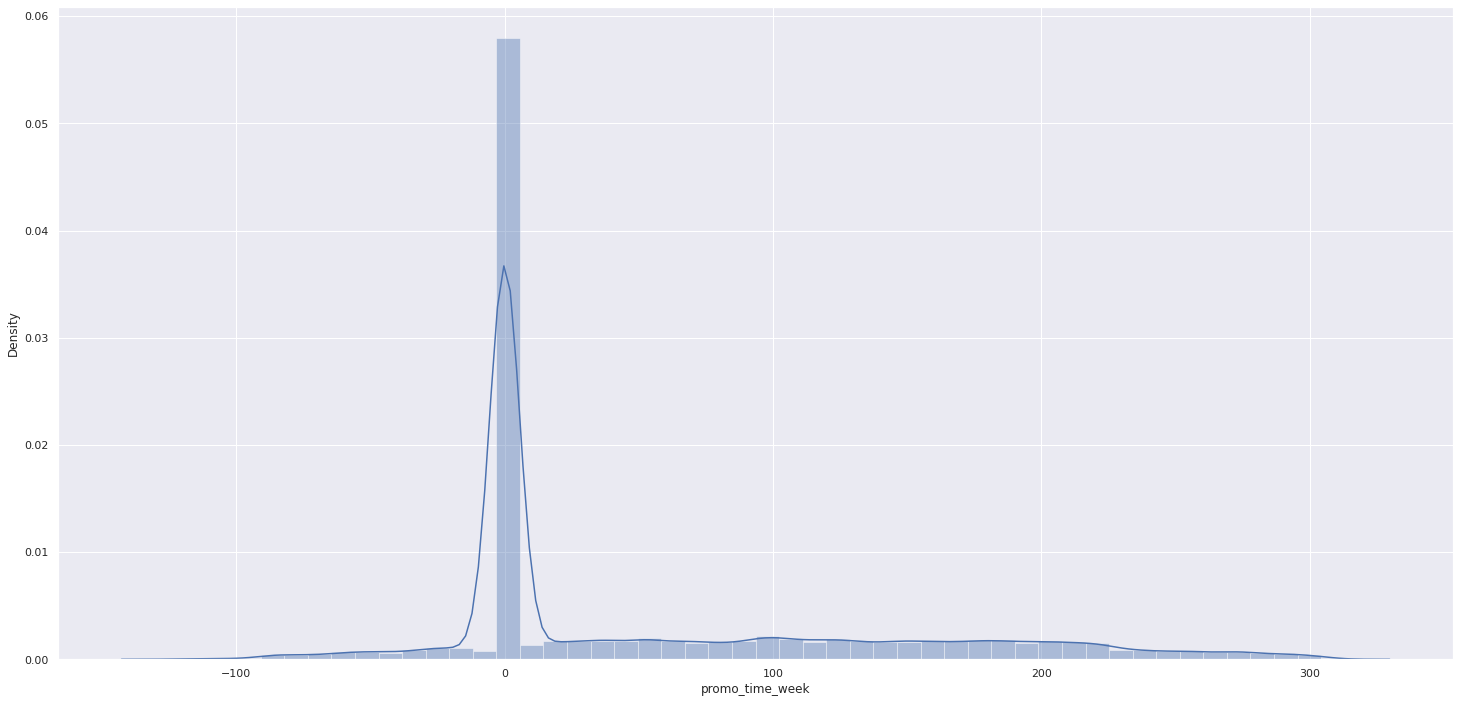

In [34]:
sns.distplot(df4['promo_time_week'])

<AxesSubplot:xlabel='promo_time_week'>

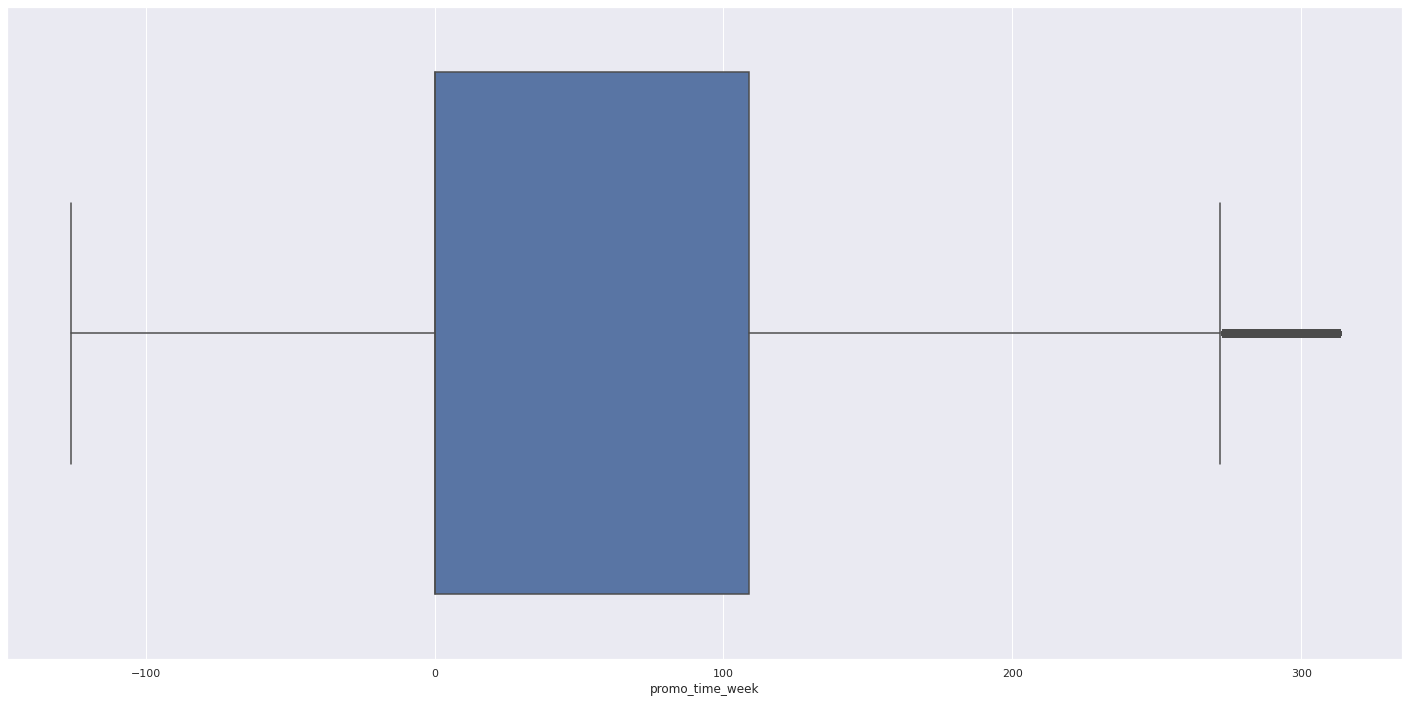

In [35]:
sns.boxplot(x = df4['promo_time_week'])

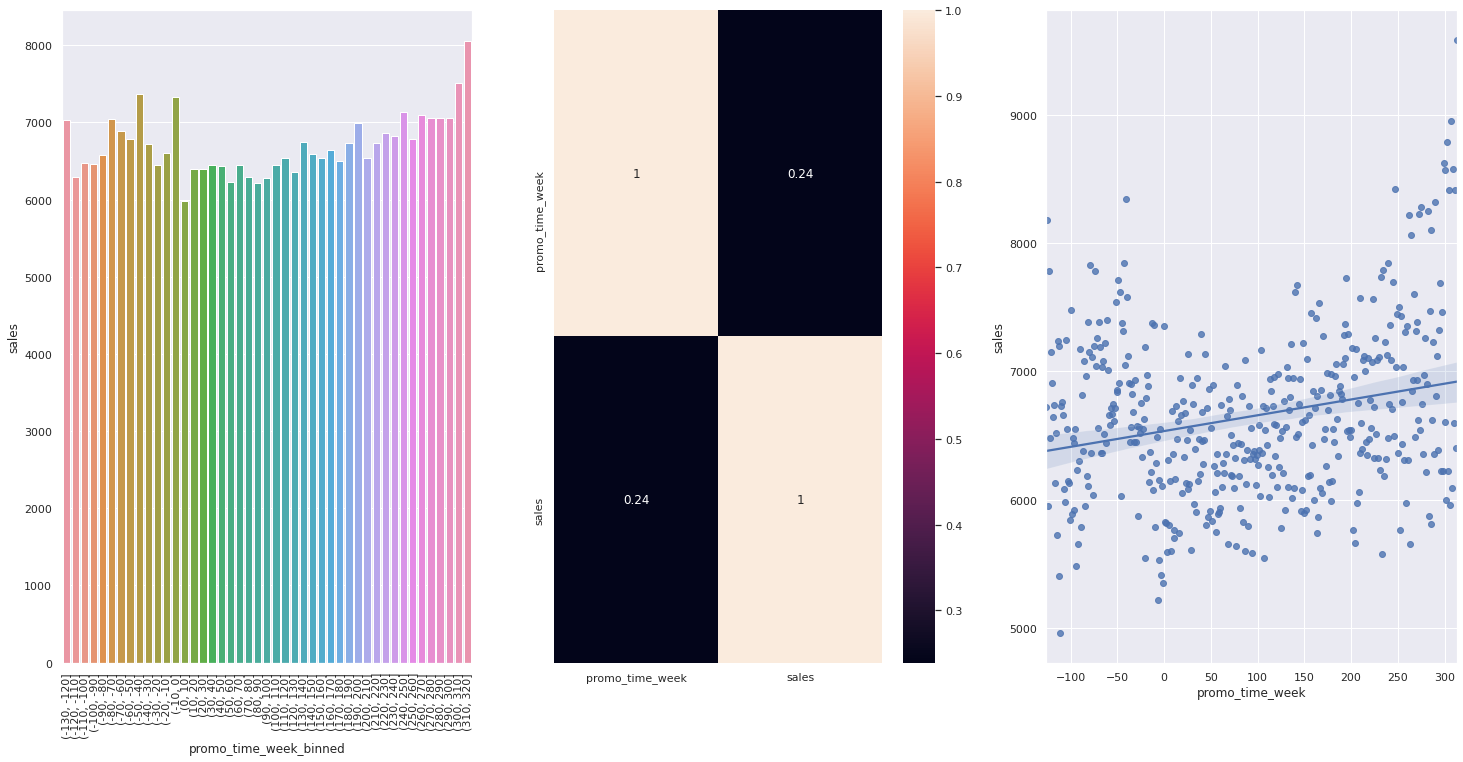

In [36]:
bins = list(np.arange(-130, 330, 10))
df4['promo_time_week_binned'] = pd.cut( df4['promo_time_week'], bins=bins)

aux2 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

plt.subplot(1, 3, 1)
aux1 = df4[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

plt.subplot(1, 3, 3 )
sns.regplot(x='promo_time_week', y='sales', data=aux2)

df4.drop('promo_time_week_binned', axis=1, inplace=True)

### ~H5. Stores with more days of promotion should sell more.~

### 6. Stores with more consecutive promotions should sell more.
**FALSE** Stores with more consecutive promotions sell less.

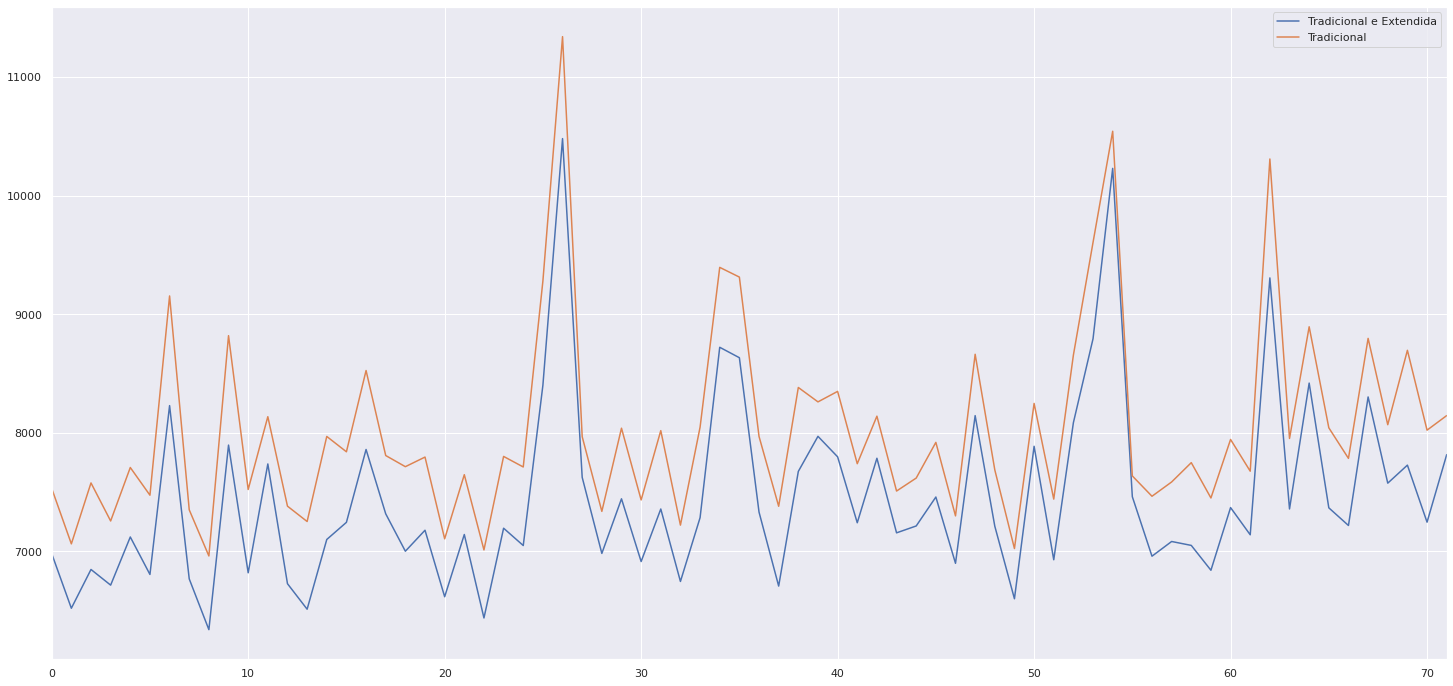

In [37]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Tradicional']);

### H7. Stores open on Christmas Day should sell more.
**TRUE** Stores open on Christmas Day sell more.

<AxesSubplot:xlabel='year', ylabel='sales'>

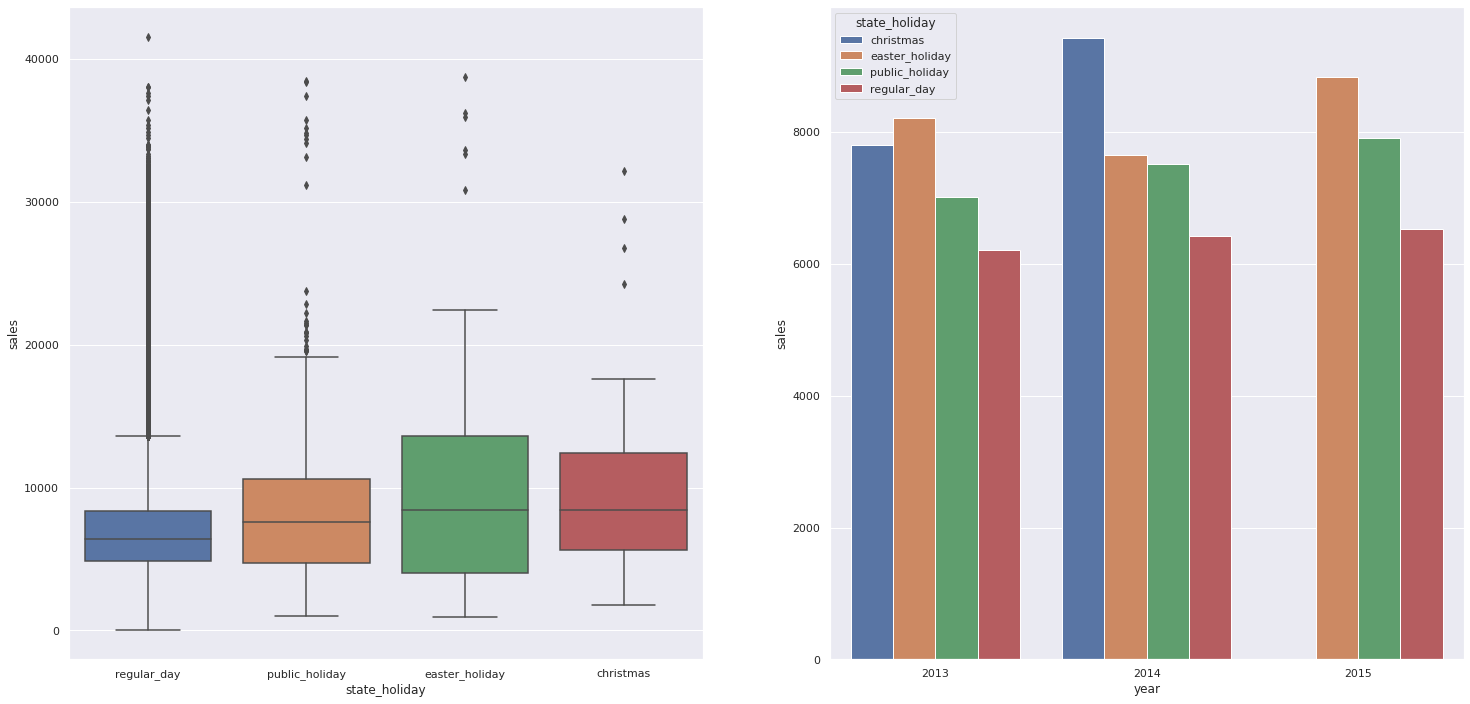

In [38]:
plt.subplot(1, 2, 1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.boxplot(x='state_holiday', y='sales', data=df4)

plt.subplot(1, 2, 2)
aux1 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1)

### H8. Stores should sell more over the years.
**TRUE** Stores sell more over the years.

<AxesSubplot:>

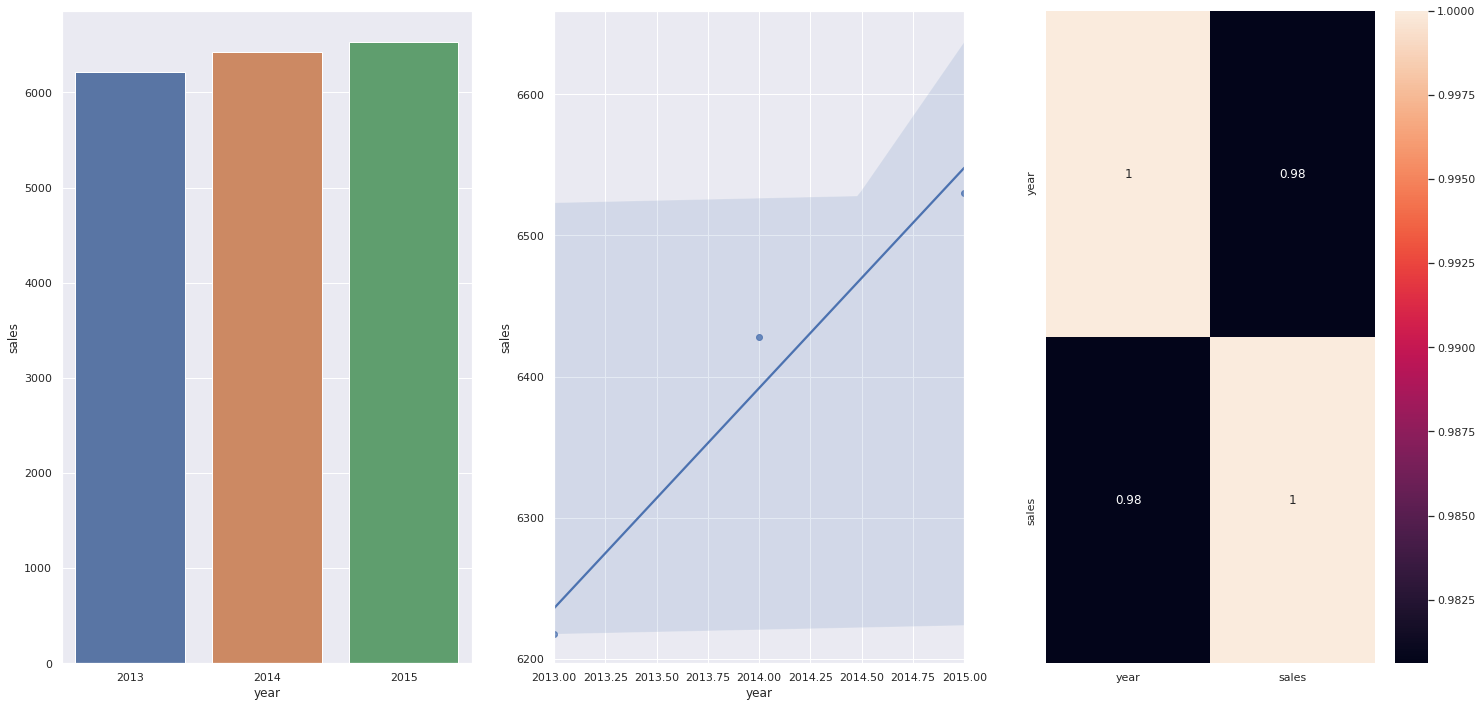

In [39]:
aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

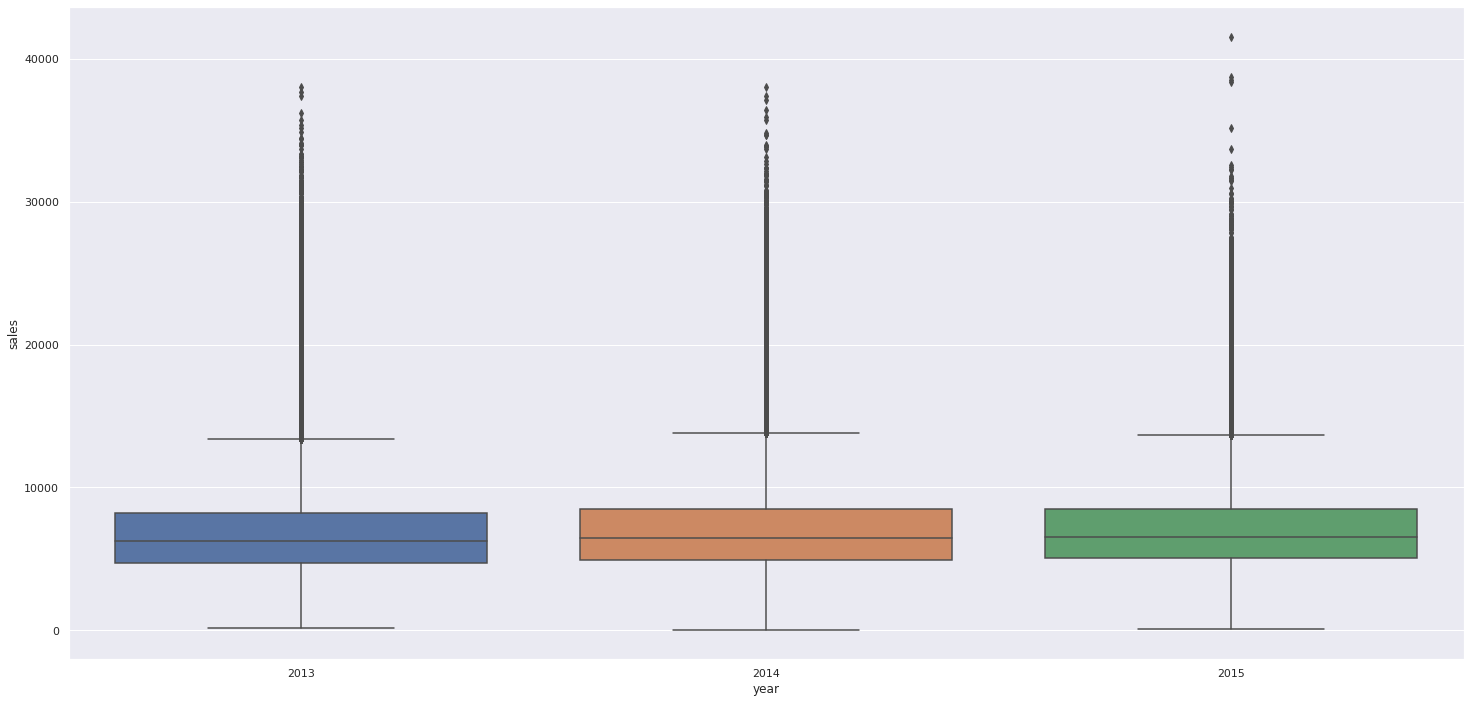

In [40]:
sns.boxplot(x='year', y='sales', data=df4);

### H9. Stores should sell more in the second half of the year.
**TRUE** Stores sell more in the second half of the year.

<AxesSubplot:xlabel='month', ylabel='sales'>

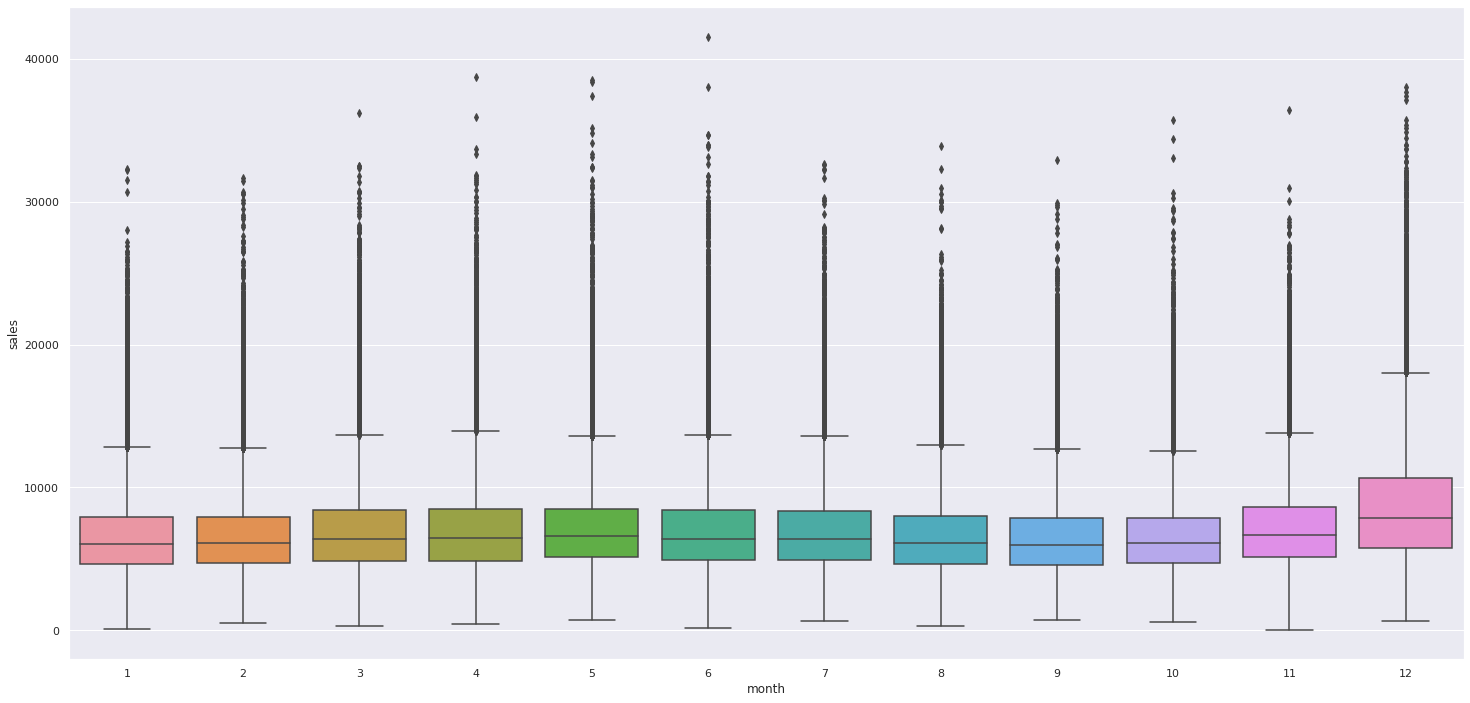

In [41]:
sns.boxplot(x='month', y='sales', data=df4)

<AxesSubplot:>

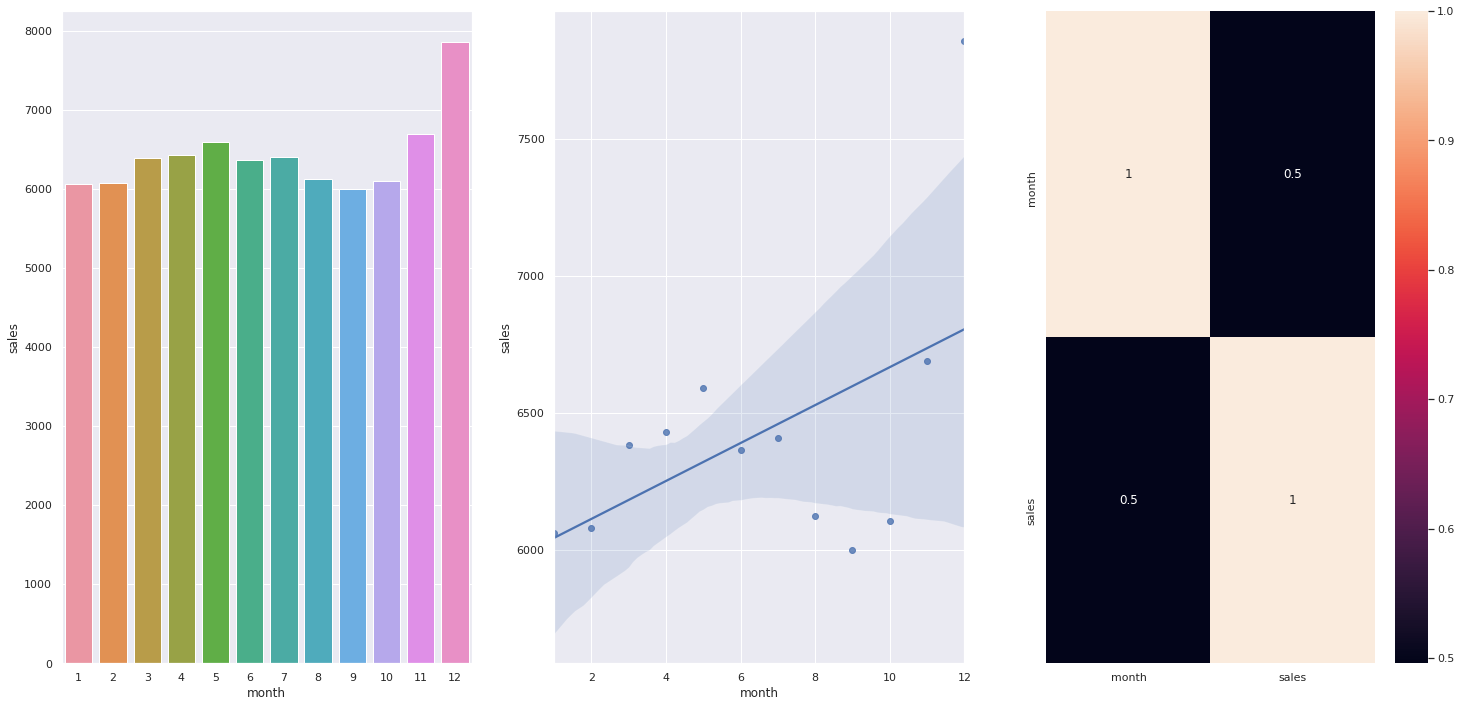

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

### H10. Stores should sell more after the 10th of each month.
**FALSO** Stores sell less after the 10th of each month.

<AxesSubplot:xlabel='day', ylabel='sales'>

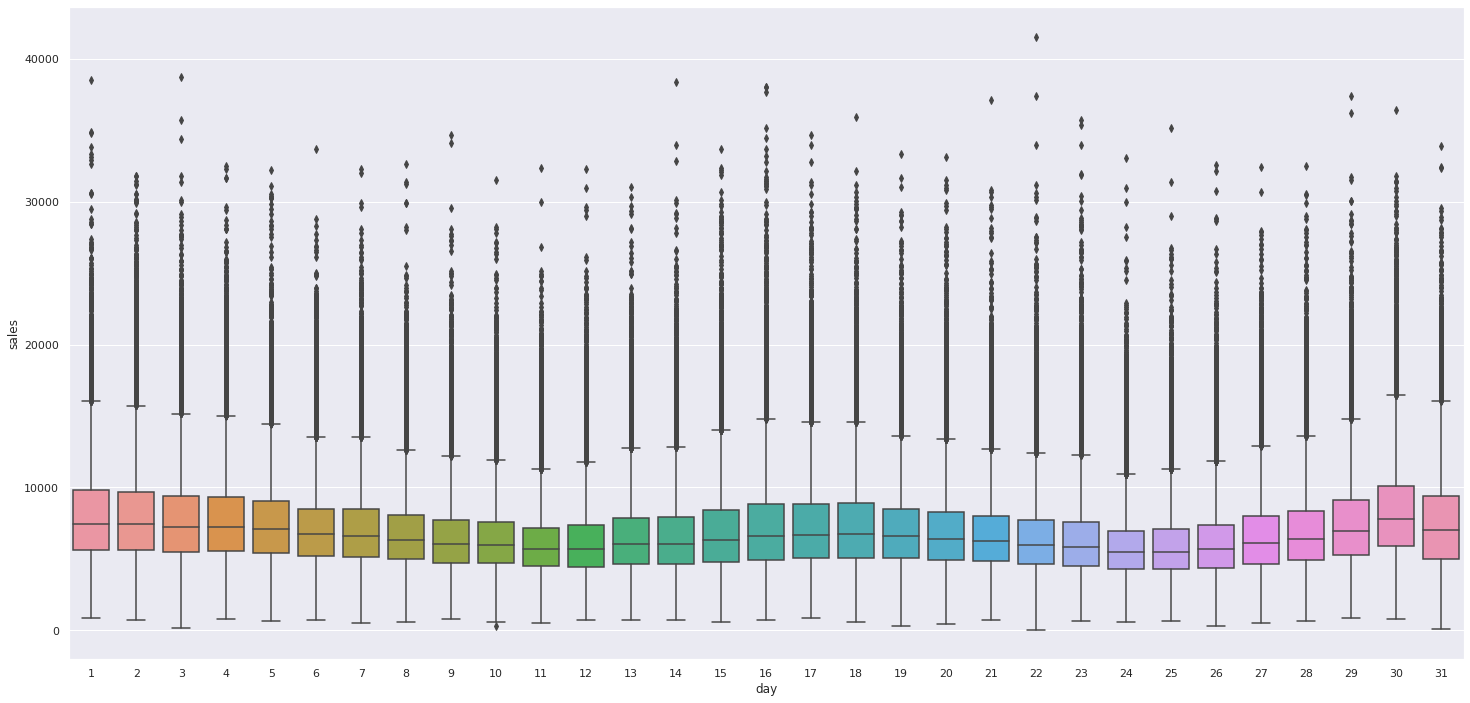

In [43]:
sns.boxplot(x='day', y='sales', data=df4)

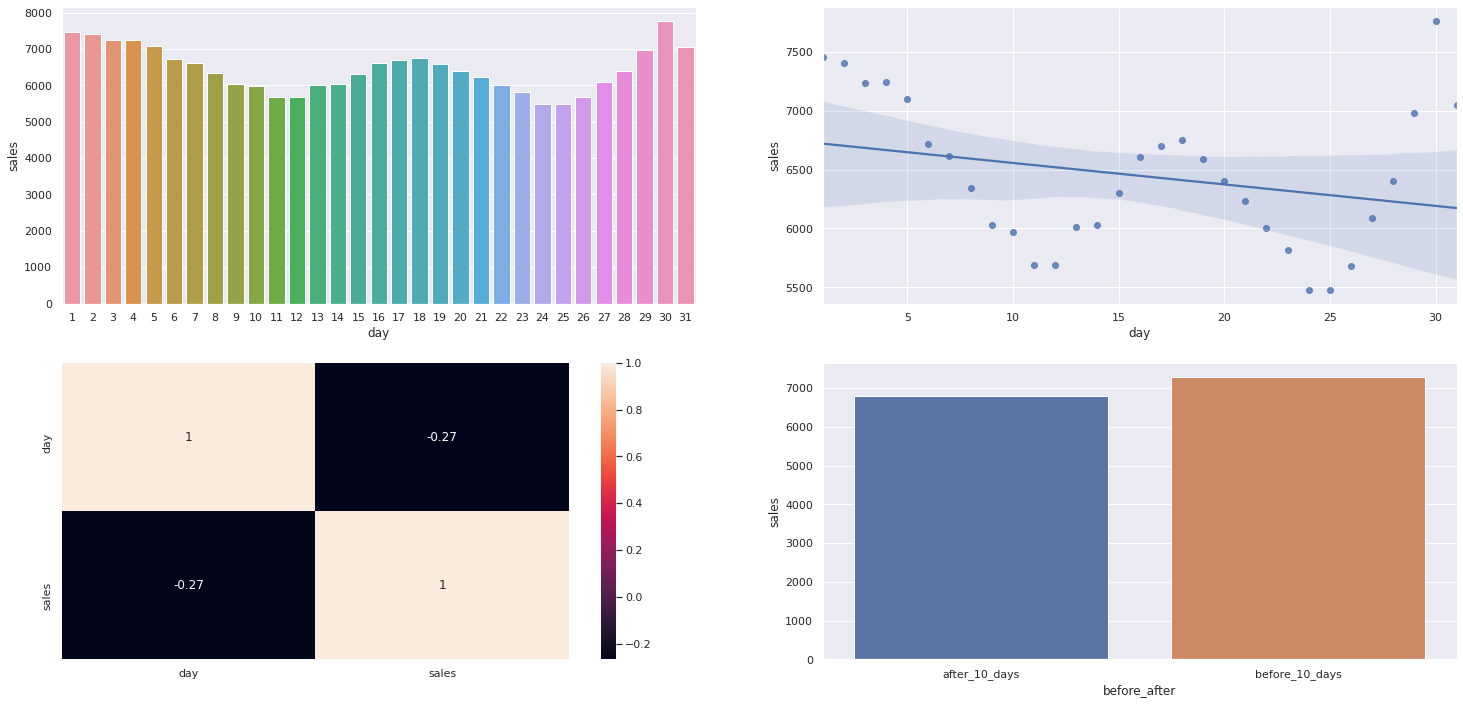

In [44]:
aux1 = df4[['day', 'sales']].groupby('day').median().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = df4[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

df4.drop(columns='before_after', inplace=True)

### H11. Stores should sell less on weekends.
**TRUE** Stores sell less on weekends

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

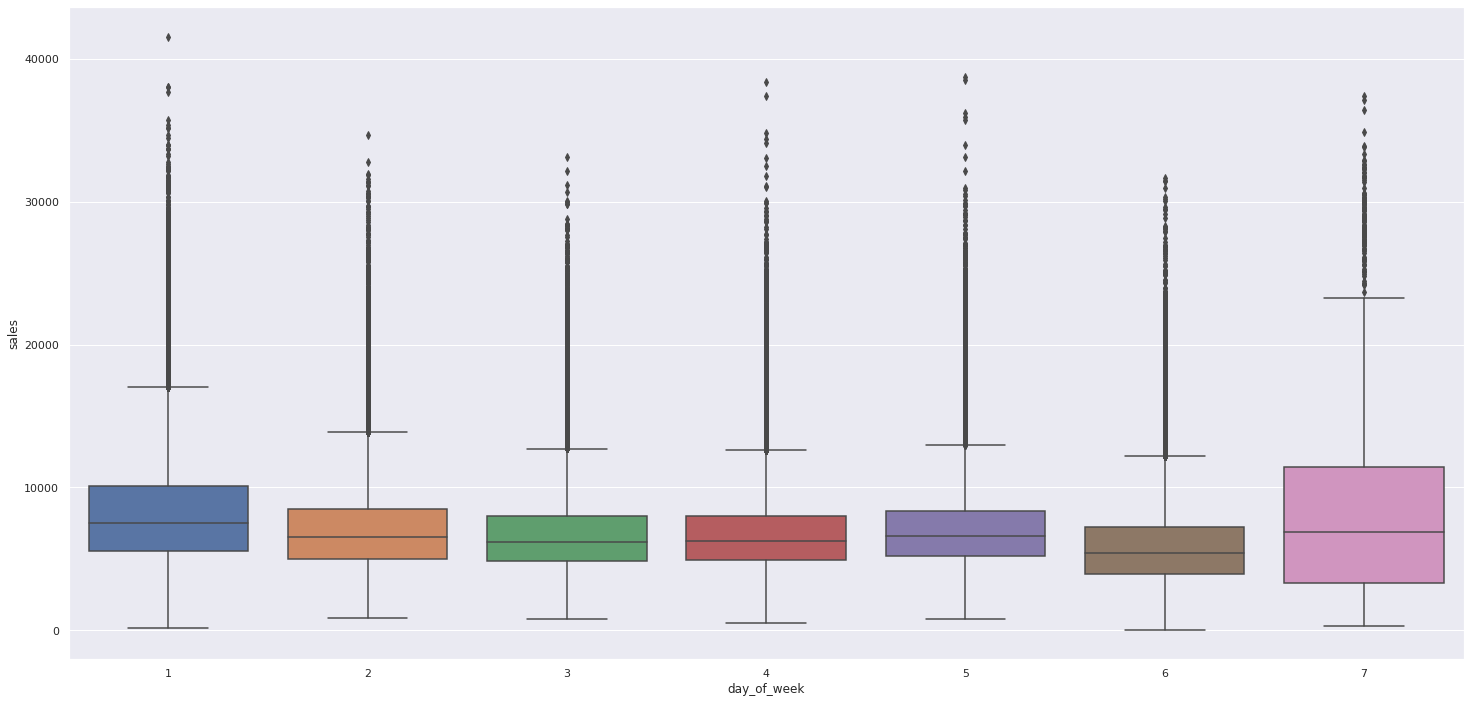

In [45]:
sns.boxplot(x='day_of_week', y='sales', data=df4)

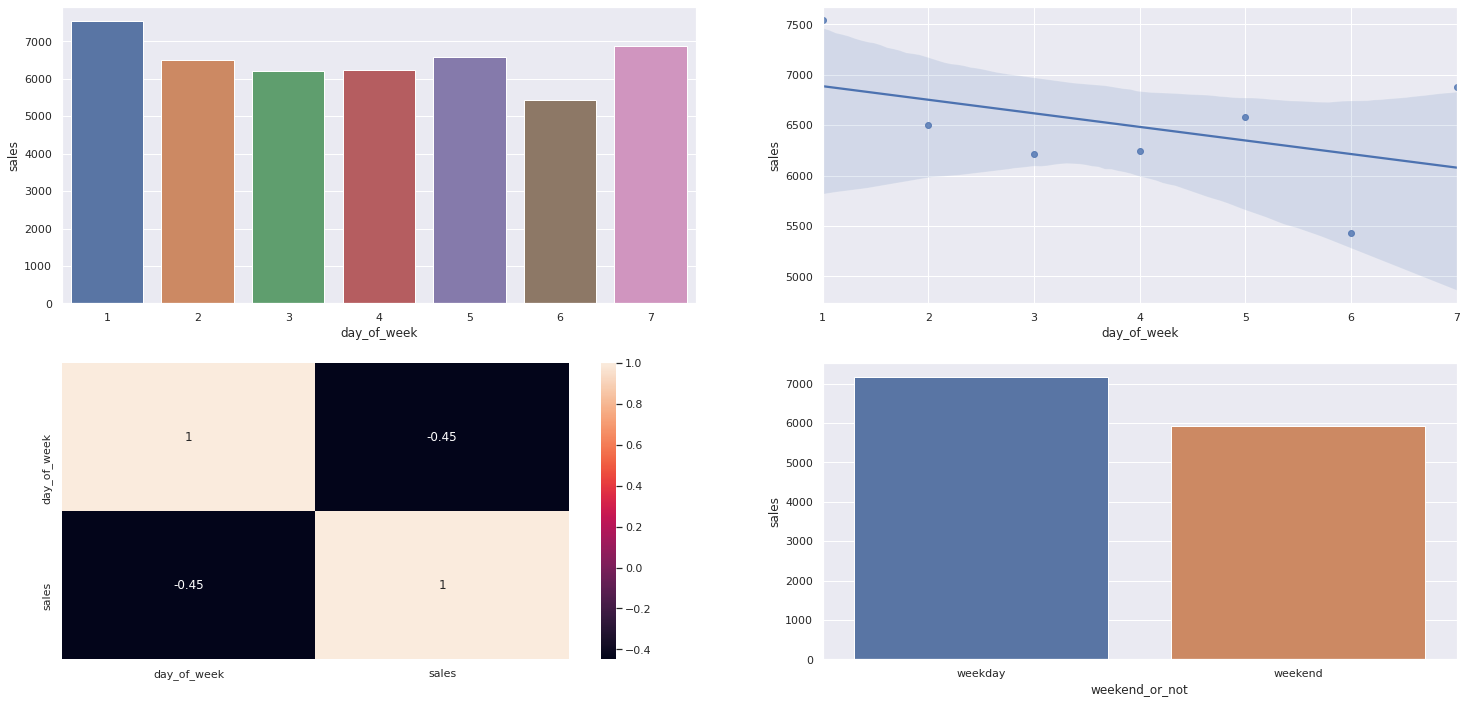

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr( method='pearson' ), annot=True)

df4['weekend_or_not'] = df4['day_of_week'].apply(lambda x: 'weekend' if x >= 6 else 'weekday')
aux2 = df4[['weekend_or_not', 'sales']].groupby('weekend_or_not').mean().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='weekend_or_not', y='sales', data=aux2)

df4.drop('weekend_or_not', axis=1, inplace=True)

### H12. Stores should sell less during school holidays.
**FALSO** Store sell a little more during school holidays.

<AxesSubplot:xlabel='school_holiday', ylabel='sales'>

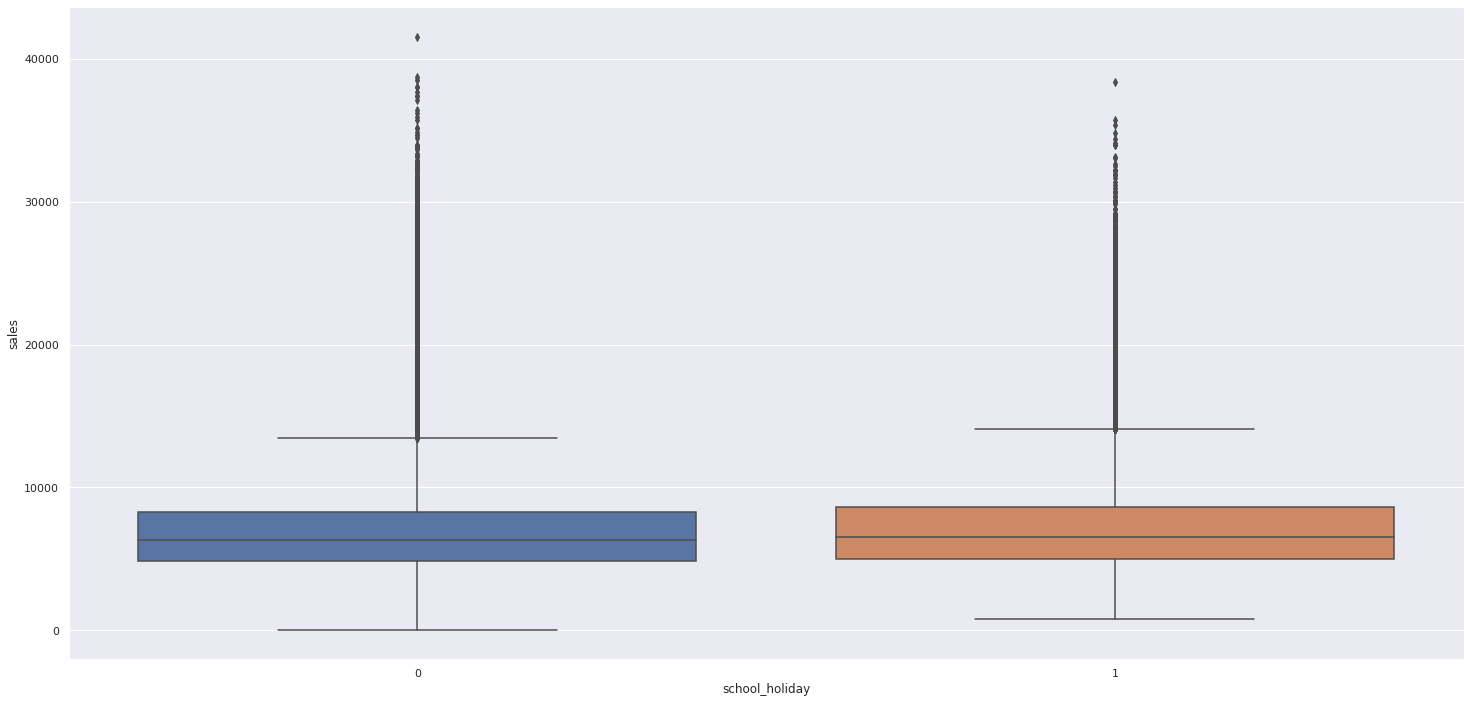

In [47]:
sns.boxplot(x = 'school_holiday', y='sales', data=df4)

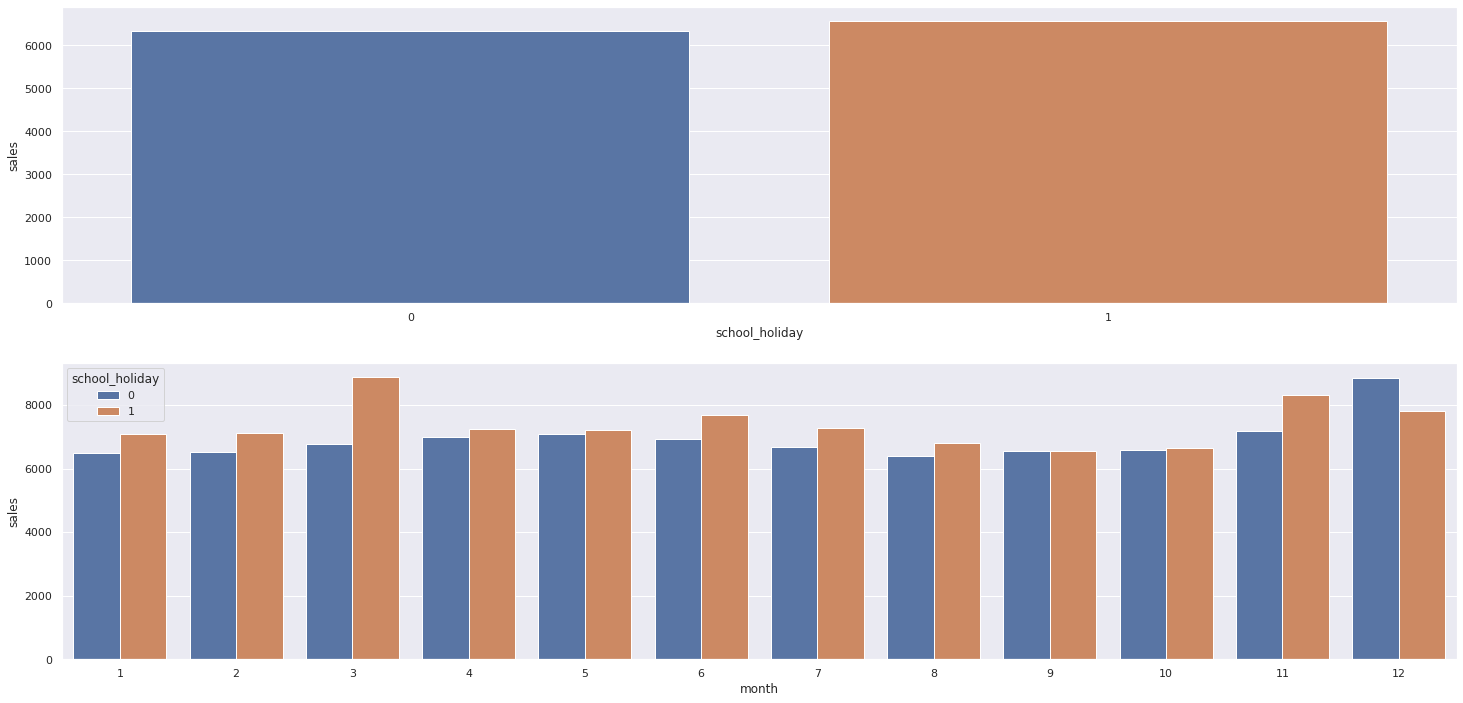

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## Hypothesis Resume

In [49]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'Medium'],  
      ['H2', 'False', 'Low'],  
      ['H3', 'False', 'Low'],
      ['H4', 'True', 'High'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'True', 'Medium'],
      ['H8', 'True', 'High'],
      ['H9', 'True', 'High'],
      ['H10', 'False', 'Medium'],
      ['H11', 'True', 'High'],
      ['H12', 'False', 'Low']
      ]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          Medium
H2            False         Low
H3            False         Low
H4            True          High
H5            -             -
H6            False         Low
H7            True          Medium
H8            True          High
H9            True          High
H10           False         Medium
H11           True          High
H12           False         Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

<AxesSubplot:>

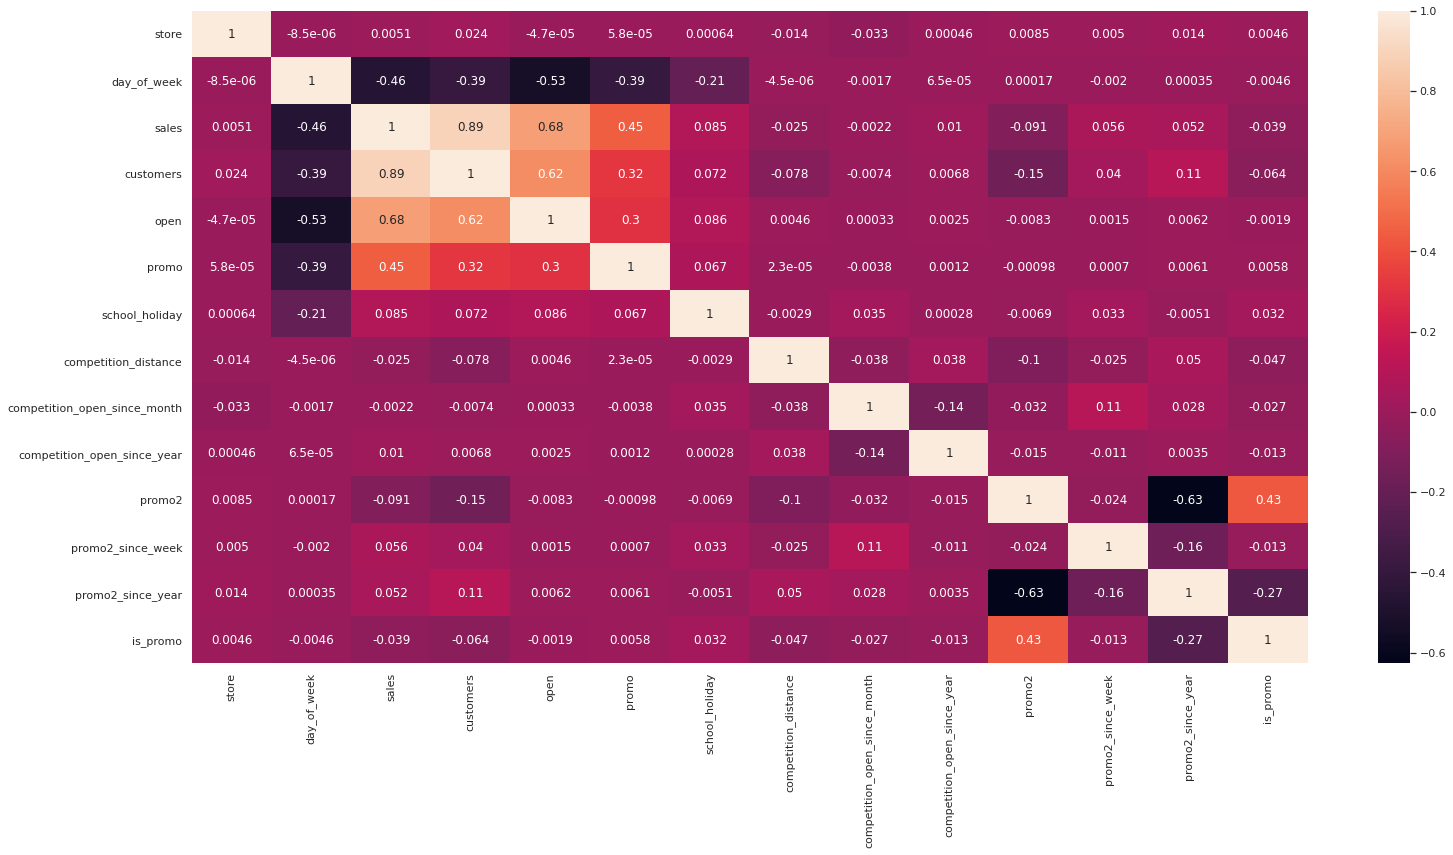

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

In [51]:
a = df4.select_dtypes(include='object')

<AxesSubplot:>

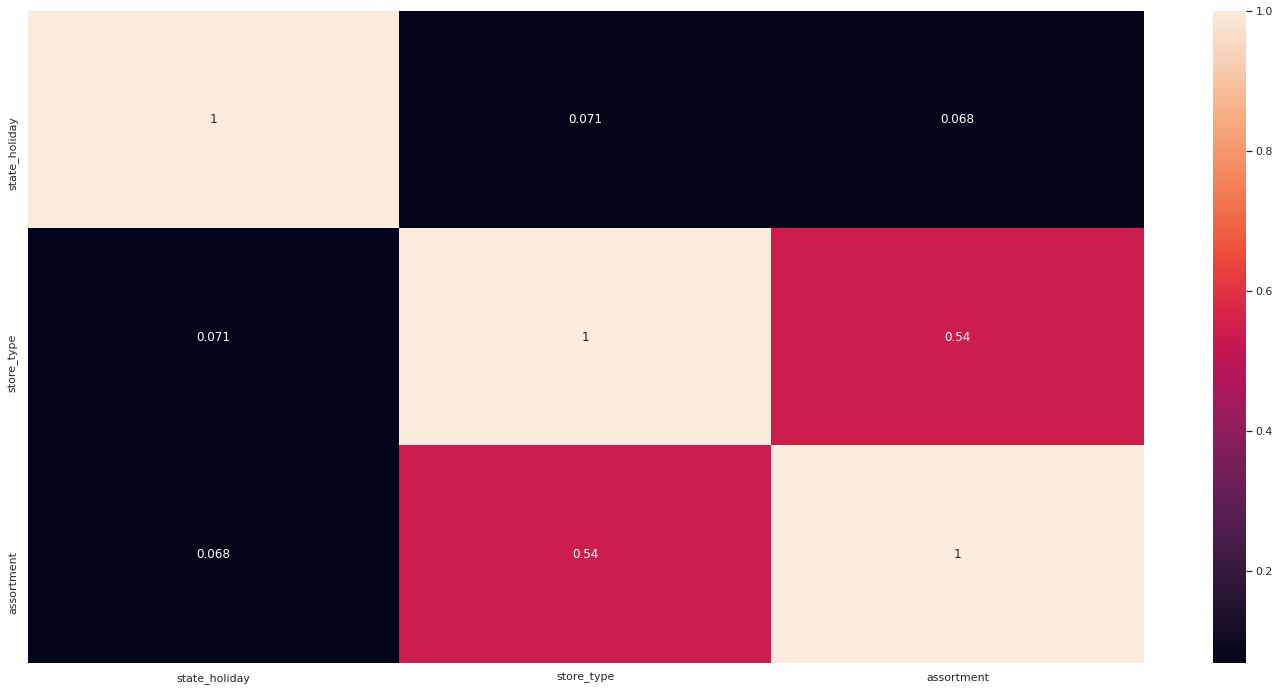

In [52]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9],
                 })

d = d.set_index(d.columns)

# Plot
sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance -> RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# year -> MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# competition_time_month -> RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week -> MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open( 'parameter/store_type_scaler.pkl', 'wb'))

# assortment -> Orginal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

### 5.3.2. Response Variable Transformation

In [56]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [57]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *( 2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0. FEATURE SELECTION

In [58]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset


In [59]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [60]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [61]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [63]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [64]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [66]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso


In [68]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [70]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


## 7.4.1. Random Forest Regresor - Cross Validation

In [71]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5. XGBoost Regressor

In [72]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6739,0.949475,7330.979785


### 7.5.1 XGBoost Regressor - Cross Validation

In [73]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [74]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.673900,0.949475,7330.979785


### 7.6.2. Real Performance - Cross Validation

In [75]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [76]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 15

In [77]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#    print(hp)
#    
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'], 
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])
#        
#final_result

## 8.2. Final Model

In [78]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [79]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,769.418442,0.115452,1103.863993


In [80]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.016993293553199094

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

In [81]:
df9 = X_test.loc[:, cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [82]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [83]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106171.351562,102781.272397,109561.430728,3390.079166,0.587557
908,909,222328.015625,214455.375870,230200.655380,7872.639755,0.518544
901,902,198744.593750,197370.631757,200118.555743,1373.961993,0.341750
169,170,202679.281250,201303.897177,204054.665323,1375.384073,0.338774
875,876,197616.000000,193510.122442,201721.877558,4105.877558,0.335593


<AxesSubplot:xlabel='store', ylabel='MAPE'>

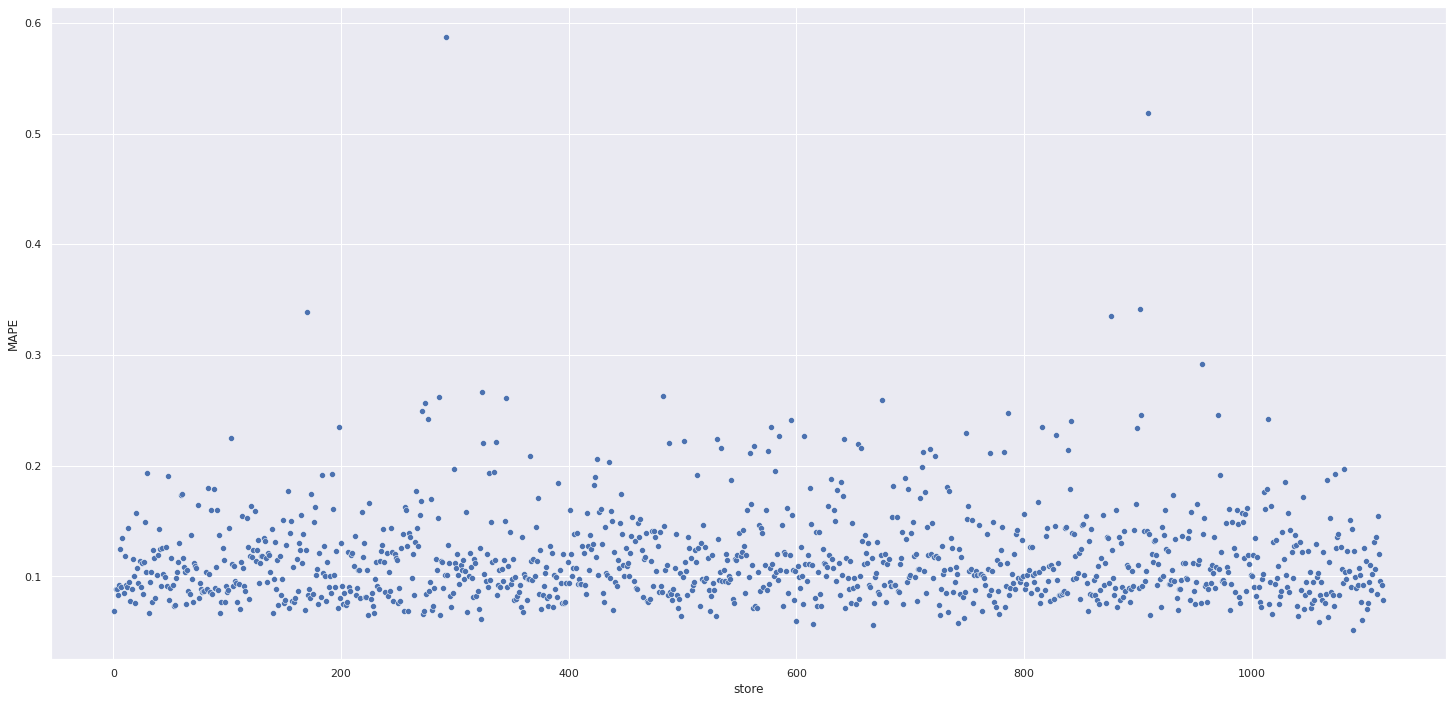

In [84]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [85]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,304,303.98"
1,worst_scenario,"R$285,443,146.28"
2,best_scenario,"R$287,165,461.67"


## 9.3. Machine Learning Performance

In [86]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/home/tcbm/.pyenv/versions/3.8.0/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='error'>

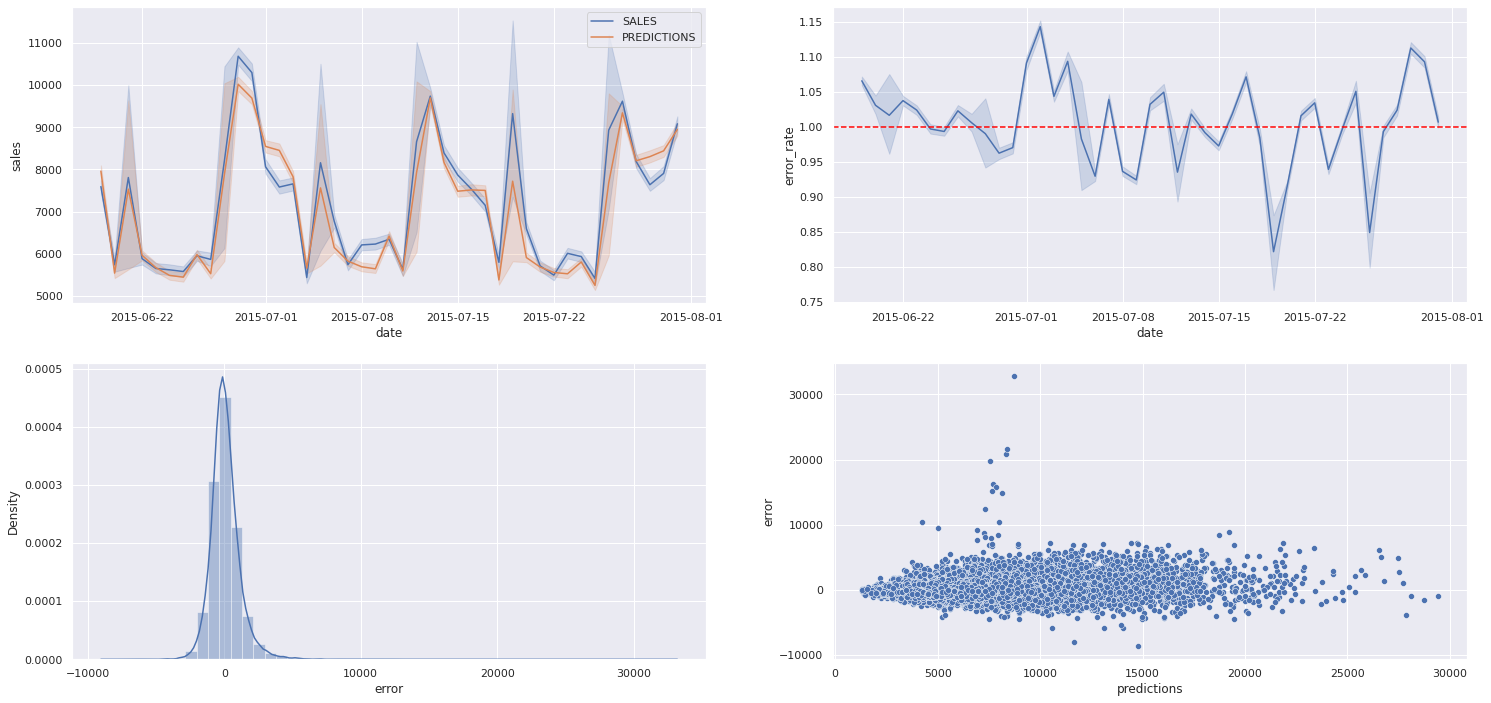

In [87]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--', color='red')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x = df9['predictions'], y = df9['error'])

# 10.0. DEPLOY MODEL TO PRODUCTION

In [88]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open( '/home/tcbm/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb'))

In [5]:
df1 = df_raw.copy()

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/tcbm/DataScience_Em_Producao/'
        self.competition_distance_scaler        = pickle.dump(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.year_scaler                        = pickle.dump(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.competition_time_month_scaler      = pickle.dump(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler             = pickle.dump(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.store_type_scaler                  = pickle.dump(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data cleaning(self, df1):
        
        # Rename Columns
        
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))
        
        # DataTypes
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        
        # Fillout NA
        
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
    
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        # Filtering rows
        df2 = df2[df2['open'] != 0]
        
        # Select Columns
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        
    def data_preparation(self, df5):
        
        # Rescaling
        
        # competition_distance -> RobustScaler
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # year -> MinMaxScaler
        df5['year'] = self.year_scaler.competition_time_month.fit_transform(df5[['year']].values)
        
        # competition_time_month -> RobustScaler
        df5['competition_time_month'] = self.competition_time_month.fit_transform(df5[['competition_time_month']].values)
        
        # promo_time_week -> MinMaxScaler
        df5['promo_time_week'] = self.promo_time_week.fit_transform(df5[['promo_time_week']].values)

        # Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment -> Orginal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict)
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 )))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

        # day 
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *( 2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *( 2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                                'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'
                               ]
        
        return df5[cols_selected_boruta]
    
        
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.exmp1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [89]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/tcbm/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
        
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0]) 
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # instanciate Rossmann class
        pipeline = Rossmann()
    
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'flask'

## 10.3. API Tester

In [117]:
import json
import requests

In [118]:
# loading test dataset
df10 = pd.read_csv('/home/tcbm/DataScience_Em_Producao/data/test.csv')

In [142]:
# merge test dataset _ store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([23, 56, 1])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [143]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [144]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test-tcb.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [145]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [146]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
           d2.loc[i, 'store'],
           d2.loc[i, 'prediction']))

Store Number 1 will sell R$152,574.47 in the next 6 weeks
Store Number 23 will sell R$242,950.97 in the next 6 weeks
Store Number 56 will sell R$379,863.53 in the next 6 weeks
